# CMPE 255 Project - Decision Tree

## Some imports

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time
import pandas as pd
import time

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFE


### Things to try out

- With/without instance weight
- Manually remove some fields I think useless
- 94 vs 95 year?

# Understanding the data

### Parse labels

In [2]:
train_filename = '../census/labels.data'

with open(train_filename, 'r', encoding='utf8') as label_file:
    train_lines = label_file.readlines()

In [3]:
print(len(train_lines))

# key -> set of values
column_names = []
column_values = []
for l in train_lines:
    l = l.lower().strip()
    column_index = l.index(':')
    column_names.append(l[:column_index])
    values = l[column_index + 2:]
    if values == 'continuous':
        column_values.append('continuous')
    else:
        values = [x.strip() for x in values.split(',')]
        column_values.append(set(values))

    

41


In [4]:
print([len(a) for a in column_values])

[10, 9, 52, 47, 17, 10, 3, 7, 24, 15, 5, 10, 2, 3, 6, 8, 10, 10, 10, 6, 6, 50, 38, 8, 10, 9, 8, 9, 3, 3, 10, 5, 42, 42, 42, 5, 3, 3, 3, 10, 2]


In [5]:
print(column_names[24])
print(column_values[24])

instance weight
continuous


## Read data file


In [6]:
def parse_data_line(data_line, data_labels, data_weight, data_matrix):
    # -1 to remove the ending period
    splits = l[:-1].lower().split(',')
    trimmed = [v.strip() for v in splits]
    line = []
    for i in range(len(trimmed)):
        v = trimmed[i]

        # Instance weight column
        if i == 24:
            data_weight.append(float(v))
            continue

        # label column
        if i == 41:
            if '-' in v:
                data_labels.append(0)
            else:
                data_labels.append(1)
                continue
        else: 
            if v == '?':
                line.append(None)
                continue
            
            column_value = column_values[i]
            
            if column_value == 'continuous':
                line.append(float(v))
            else:
                if v not in column_value:
                    print('Data not match desired value for column [$d]: ', i, v)
                    line.append(None)
                else:
                    line.append(v)
    data_matrix.append(line)

In [9]:
data_filename = '../census/census-income.data'
test_filename= '../census/census-income.test'

with open(data_filename, 'r', encoding='utf8') as data_file:
    data_lines = data_file.readlines()
    
with open(test_filename, 'r', encoding='utf8') as test_file:
    test_lines = test_file.readlines()

data_labels = []
data_weight = []
data_matrix = []
start = time.time()
for l in data_lines:
    parse_data_line(l, data_labels, data_weight, data_matrix)

test_labels = []
test_weight = []
test_matrix = []
for l in test_lines:
    parse_data_line(l, test_labels, test_weight, test_matrix)
    
print("Parsing all data lines took: ", time.time()-start)
        

Parsing all data lines took:  7.419291257858276


In [10]:
# Convert arrays into numpy array
data_labels = np.array(data_labels)
data_weight = np.array(data_weight)
data_matrix = np.array(data_matrix)

test_labels = np.array(test_labels)
test_weight = np.array(test_weight)
test_matrix = np.array(test_matrix)

In [11]:
print(data_matrix.shape)
print(test_matrix.shape)
print(test_labels.shape)
print(test_weight)
print(len(column_names))

(199523, 40)
(99762, 40)
(99762,)
[1032.38 1462.33 1601.75 ... 2083.76 1680.06 1582.48]
41


### Remove the instance weight column from column name and values

In [12]:
del(column_names[24])
del(column_values[24])

### Gather index of year 94 vs 95

In [13]:
year_94_train = []
year_95_train = []

for i in range(len(data_matrix)):
    if data_matrix[i][-1] == '94':
        year_94_train.append(i)
    else:
        year_95_train.append(i)

year_94_test = []
year_95_test = []

for i in range(len(data_matrix)):
    if data_matrix[i][-1] == '94':
        year_94_test.append(i)
    else:
        year_95_test.append(i)

In [14]:
print("Number of instance for year 94: ", len(year_94_train))
print("Number of instance for year 95: ", len(year_95_train))

Number of instance for year 94:  99827
Number of instance for year 95:  99696


In [16]:
print(np.sum(data_weight[year_94_train]))
print(np.sum(data_weight[year_95_train]))

172570585.16
174675307.31


In [17]:
weight_plus = np.sum([data_weight[i] if data_labels[i] == 1 else 0 for i in range(len(data_labels))])
weight_minus = np.sum([data_weight[i] if data_labels[i] == 0 else 0 for i in range(len(data_labels))])


In [18]:
print("Weighted positive instances: ", weight_plus, weight_plus/(weight_plus + weight_minus))
print("Weighted negative instances: ", weight_minus, weight_minus/(weight_plus + weight_minus))


Weighted positive instances:  22241245.249999993 0.06405041998278353
Weighted negative instances:  325004647.22 0.9359495800172164


### Visualize the instance weight

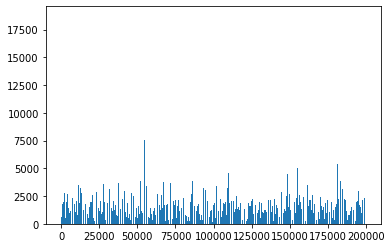

In [15]:
plt.bar([i for i in range(len(data_weight))], 
       data_weight)
plt.show()

# Preprocessing

## Transform categorical data into binary

In [19]:
categorical_columns = list(filter(lambda x: column_values[x] != 'continuous', [i for i in range(len(column_values))]))
print("Number of nomincal features: ", len(categorical_columns))

Number of nomincal features:  33


In [20]:
print(categorical_columns)

[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39]


In [49]:
# df = pd.DataFrame(data_matrix)
# df = df.where(pd.notnull(df), 'Others')

In [21]:
categorical_matrix_train = data_matrix[:,categorical_columns]
categorical_matrix_test = test_matrix[:, categorical_columns]
categorical_values = (np.array(column_values))[categorical_columns]

In [23]:
categorical_values = [list(l) for l in categorical_values]
print(len(categorical_values))


33


In [24]:
# Ignore is needed to neglect 'Other' type with question marks
ohe = OneHotEncoder(categories=categorical_values, handle_unknown='ignore')
# ct = ColumnTransformer([('One Hot Encoder', ohe, categorical_columns)], remainder='passthrough', verbose=True)
ohe.fit(categorical_matrix_train)
categorical_sparse_matrix_train = ohe.transform(categorical_matrix_train)
categorical_sparse_matrix_test = ohe.transform(categorical_matrix_test)

In [25]:
print(categorical_sparse_matrix_train.nnz, len(categorical_columns) * len(data_labels))
print(categorical_sparse_matrix_train.shape)
print(type(data_matrix), data_matrix.shape)
print(categorical_sparse_matrix_test.nnz)
print(categorical_sparse_matrix_test.shape)

6168542 6584259
(199523, 495)
<class 'numpy.ndarray'> (199523, 40)
3083767
(99762, 495)


In [26]:
continuous_columns = list(filter(lambda x: column_values[x] == 'continuous', [i for i in range(len(column_values))]))
print(continuous_columns)

[0, 5, 16, 17, 18, 29, 38]


In [28]:
continuous_dense_matrix_train = np.array(data_matrix[:, continuous_columns], dtype=float)
continuous_dense_matrix_test = np.array(test_matrix[:, continuous_columns], dtype=float)
continuous_dense_matrix_train

array([[ 73.,   0.,   0., ...,   0.,   0.,   0.],
       [ 58.,   0.,   0., ...,   0.,   1.,  52.],
       [ 18.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [ 47.,   0.,   0., ..., 157.,   6.,  52.],
       [ 16.,   0.,   0., ...,   0.,   0.,   0.],
       [ 32.,   0.,   0., ...,   0.,   6.,  52.]])

In [29]:
continuous_sparse_matrix_train = scipy.sparse.csr_matrix(continuous_dense_matrix_train)
continuous_sparse_matrix_test = scipy.sparse.csr_matrix(continuous_dense_matrix_test)

print(continuous_sparse_matrix_train.shape, continuous_sparse_matrix_train.nnz)
print(continuous_sparse_matrix_test.shape, continuous_sparse_matrix_test.nnz)

(199523, 7) 447494
(99762, 7) 223821


In [30]:
sparse_data_matrix = scipy.sparse.hstack([continuous_dense_matrix_train, categorical_sparse_matrix_train], format='csr')
sparse_test_matrix = scipy.sparse.hstack([continuous_dense_matrix_test, categorical_sparse_matrix_test], format='csr')

print(sparse_data_matrix.shape, sparse_data_matrix.nnz)
print(sparse_test_matrix.shape, sparse_test_matrix.nnz)

(199523, 502) 6616036
(99762, 502) 3307588


# Classifications


## Helper Functions

In [33]:
def get_measures(expected, actual, average='binary'):
    accuracy = accuracy_score(expected, actual)
    precision, recall, f_score, s = precision_recall_fscore_support(expected, actual, average=average)
    return accuracy, precision, recall, f_score

In [36]:
def run_dt_with_params(
    train_weights=[],
    criterion='gini', 
    max_depth=None,
    min_impurity_decrease=0.0,
    boost=False,
    feature_selections=None, 
    average='binary'
):
    train_measures = np.zeros(6, dtype=float)
    test_measures = np.zeros(6, dtype=float)
    depth = 0
    dt = DecisionTreeClassifier(
        criterion=criterion, 
        max_depth=max_depth, 
        min_impurity_decrease=min_impurity_decrease
    )

    if boost:
        gbc = GradientBoostingClassifier(
            init=dt, 
            max_depth=max_depth, 
            min_impurity_decrease=min_impurity_decrease
        )
        dt = gbc

    if feature_selections:
        d_matrix = sparse_data_matrix[:,feature_selections]
        t_matrix = sparse_test_matrix[:,feature_selections]
    else:
        d_matrix = sparse_data_matrix
        t_matrix = sparse_test_matrix
        
    start = time.time()
    if len(train_weights) > 0:
        dt.fit(d_matrix, data_labels, sample_weight=train_weights)
    else:
        dt.fit(d_matrix, data_labels)

    training_time = time.time()-start

    start = time.time()
    train_results = dt.predict(d_matrix)
    test_results = dt.predict(t_matrix)
    predicting_time = time.time()-start

    train_measures += list(get_measures(data_labels, train_results, average=average) + (training_time, predicting_time))
    test_measures += list(get_measures(test_labels, test_results, average=average) + (training_time, predicting_time))
    if not boost:
        depth += dt.tree_.max_depth
    
    return train_measures, test_measures, depth
    

In [37]:
def plot_measures(x_axis, measures, x_label, runtime=True):
    plt.plot(x_axis, measures[:, 0:4], label=['accuracy','precision','recall','f-score'])
    plt.xlabel(x_label)
    plt.title('Measures vs ' + x_label)
    plt.legend()
    plt.show()

    if runtime:
        plt.plot(x_axis, measures[:, 4:], label=['Training time', 'Predicting time'])
        plt.xlabel(x_label)
        plt.ylabel('seconds')
        plt.title('Runtime vs ' + x_label)
        plt.legend()
        plt.show()

In [140]:
result = run_dt_with_params(sparse_data_matrix, data_labels, max_depth=4)

In [141]:
print(result)

(0.9457907108453661, 0.6126943005181347, 0.34380552414795673, 0.4404552509053285, 0.53969407081604, 0.08215880393981934)


## Decision tree with different max depth

In [311]:
x = [i for i in range(10, 31)]
dt_depth_train = []
dt_depth_test = []
dt_depth_depths = []
for depth in x:
    a,b,c = run_dt_with_params(max_depth=depth)
    dt_depth_train.append(a)
    dt_depth_test.append(b)
    dt_depth_depths.append(c)

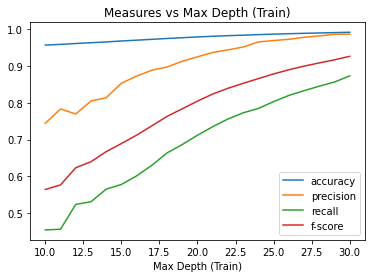

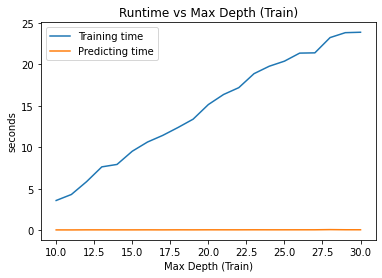

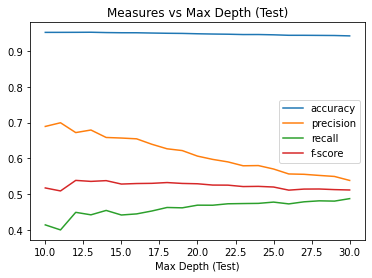

In [312]:
dt_depth_train = np.array(dt_depth_train)
dt_depth_test = np.array(dt_depth_test)
dt_depth_depths = np.array(dt_depth_depths)

plot_measures(x, dt_depth_train, 'Max Depth (Train)')
plot_measures(x, dt_depth_test, 'Max Depth (Test)', runtime=False)
# plot_measures(x, dt_depth_train, 'Max Depth (Depth)', runtime=False)

In [313]:
print(dt_depth_test[-1])

[ 0.94227261  0.53811819  0.48722923  0.51141088 23.85996318  0.07345605]


## Run DT with instance weight

In [104]:
x = [i for i in range(10, 51)]
dt_depth_instance_train = []
dt_depth_instance_test = []
dt_depth_instance_depths = []
for depth in x:
    a,b,c = run_dt_with_params(
        max_depth=depth, 
        train_weights=data_weight, 
        feature_selections=feature_selections,
        average='weighted'
    )
    dt_depth_instance_train.append(a)
    dt_depth_instance_test.append(b)
    dt_depth_instance_depths.append(c)

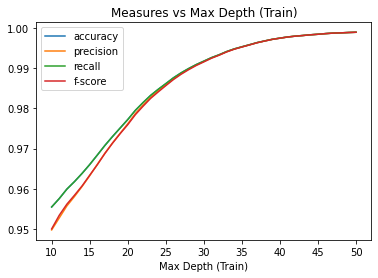

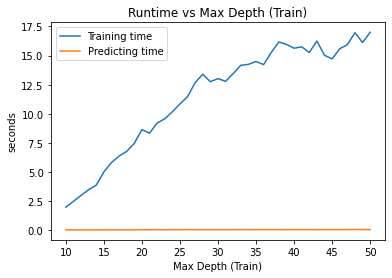

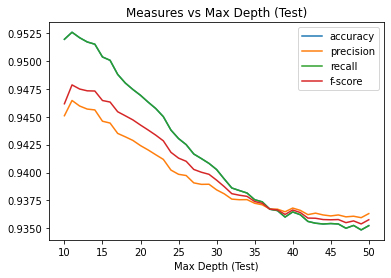

In [105]:
dt_depth_instance_train = np.array(dt_depth_instance_train)
dt_depth_instance_test = np.array(dt_depth_instance_test)
dt_depth_instance_depths = np.array(dt_depth_instance_depths)

plot_measures(x, dt_depth_instance_train, 'Max Depth (Train)')
plot_measures(x, dt_depth_instance_test, 'Max Depth (Test)', runtime=False)
# plot_measures(x, dt_depth_train, 'Max Depth (Depth)', runtime=False)

In [111]:
precision_recall_fscore_support(test_labels, [0]*len(test_labels), average='weighted')

/Users/mute/Library/Python/3.7/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.8798297836624065, 0.937992421964275, 0.907980623340771, None)

In [112]:
x = [i for i in range(10, 51)]
dt_depth_instance_train = []
dt_depth_instance_test = []
dt_depth_instance_depths = []
for depth in x:
    a,b,c = run_dt_with_params(
        max_depth=depth, 
        train_weights=data_weight, 
        average='weighted'
    )
    dt_depth_instance_train.append(a)
    dt_depth_instance_test.append(b)
    dt_depth_instance_depths.append(c)

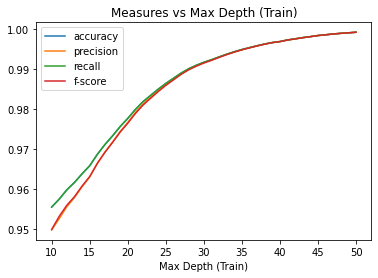

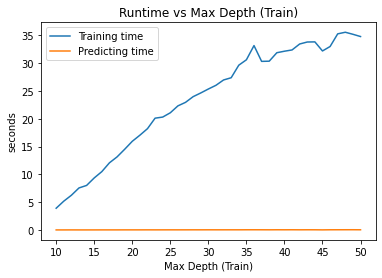

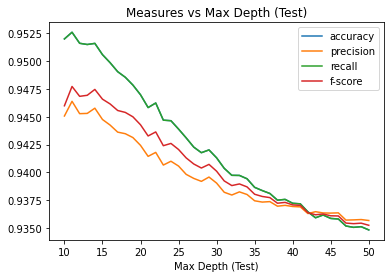

In [113]:
dt_depth_instance_train = np.array(dt_depth_instance_train)
dt_depth_instance_test = np.array(dt_depth_instance_test)
dt_depth_instance_depths = np.array(dt_depth_instance_depths)

plot_measures(x, dt_depth_instance_train, 'Max Depth (Train)')
plot_measures(x, dt_depth_instance_test, 'Max Depth (Test)', runtime=False)

## Run weighted DT against different min_impurity_decreases

In [141]:
x = [i/(10**6) for i in range(50, 0, -1)]
dt_impurity_instance_train = []
dt_impurity_instance_test = []
dt_impurity_instance_depths = []
for depth in x:
    a,b,c = run_dt_with_params(
        train_weights=data_weight,
        min_impurity_decrease=depth, 
        feature_selections=feature_selections,
        average='weighted')
    dt_impurity_instance_train.append(a)
    dt_impurity_instance_test.append(b)
    dt_impurity_instance_depths.append(c)

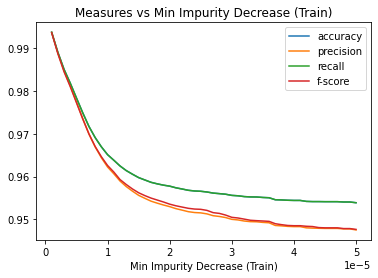

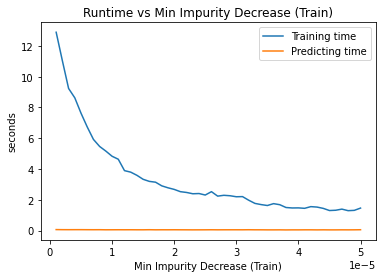

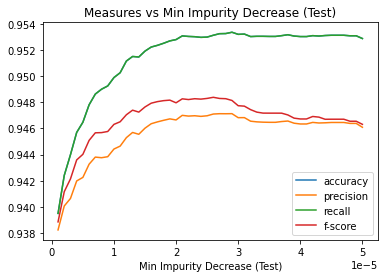

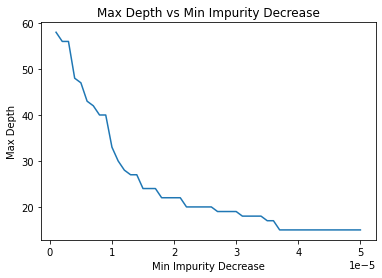

In [142]:
dt_impurity_instance_train = np.array(dt_impurity_instance_train)
dt_impurity_instance_test = np.array(dt_impurity_instance_test)
dt_impurity_instance_depths = np.array(dt_impurity_instance_depths)

plot_measures(x, dt_impurity_instance_train, 'Min Impurity Decrease (Train)')
plot_measures(x, dt_impurity_instance_test, 'Min Impurity Decrease (Test)', runtime=False)


plt.plot(x, dt_impurity_instance_depths, label=['Max depth'])
plt.ylabel('Max Depth')
plt.xlabel('Min Impurity Decrease')
plt.title('Max Depth vs Min Impurity Decrease')
plt.show()

In [143]:
max_fscore_index = np.argmax(dt_impurity_instance_test[:,3])
print("Index with maximum f score: ", max_fscore_index)
print("Minimum impurity decrease: ", x[max_fscore_index])
print("Measures: ", dt_impurity_instance_test[max_fscore_index])
print('Maximum depth: ', dt_impurity_instance_depths[max_fscore_index])
np.sum(dt_impurity_instance_test[:, 4])

Index with maximum f score:  24
Minimum impurity decrease:  2.6e-05
Measures:  [0.95312845 0.94709986 0.95312845 0.9483802  2.52529812 0.0486021 ]
Maximum depth:  20


166.18719816207886

In [135]:
dt = DecisionTreeClassifier(min_impurity_decrease=2.9e-05)
dt.fit(sparse_data_matrix, data_labels, sample_weight=data_weight)
results = dt.predict(sparse_test_matrix)

In [140]:
from sklearn.metrics import f1_score
print(f1_score(test_labels, results, average='micro'))

0.95321866041178


In [118]:
from sklearn.tree import plot_tree
ohe.feature_names_in


AttributeError: 'OneHotEncoder' object has no attribute 'feature_names_in'

In [336]:
min_value = 1
min_index = 0
for i in range(len(dt_impurity_instance_test)):
    measure = dt_impurity_instance_test[i]
    if abs(measure[1] - measure[2]) < min_value:
        min_value = abs(measure[1] - measure[2])
        min_index = i
print("Index: ", min_index)
print("Value: ", min_value)
x[min_index]

Index:  7
Value:  7.898503962711079e-05


3e-07

## Decision tree with different max depth (entropy)

In [195]:
x = [i for i in range(1, 21)]
results = []
for depth in x:
    results.append(run_dt_with_params(sparse_data_matrix, data_labels, sparse_data_matrix, max_depth=depth, criterion='entropy'))

/Users/mute/Library/Python/3.7/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mute/Library/Python/3.7/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


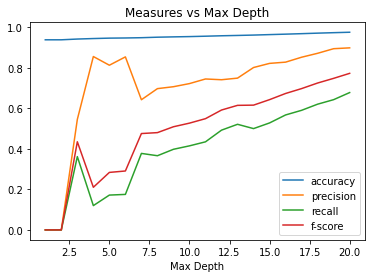

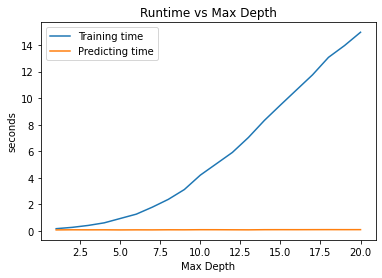

In [196]:
entropy_dt_measures = np.array(results)
plot_measures(x, entropy_dt_measures, 'Max Depth')

In [197]:
print(entropy_dt_measures[-1])

[ 0.97522591  0.89819077  0.67759651  0.77245316 14.96879506  0.09660482]


## Run DT with instance weight (entropy)

In [328]:
x = [i for i in range(1, 51)]
entropy_depth_instance_train = []
entropy_depth_instance_test = []
entropy_depth_instance_depths = []
for depth in x:
    a,b,c = run_dt_with_params(max_depth=depth, train_weights=data_weight, criterion='entropy')
    entropy_depth_instance_train.append(a)
    entropy_depth_instance_test.append(b)
    entropy_depth_instance_depths.append(c)

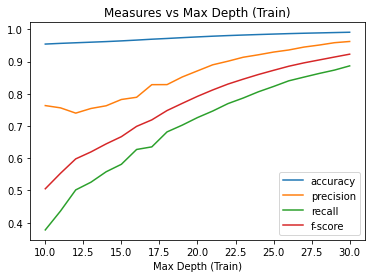

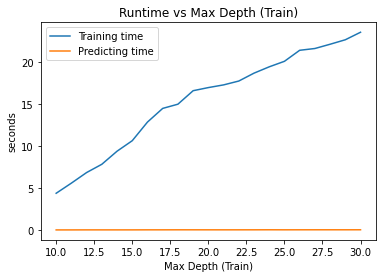

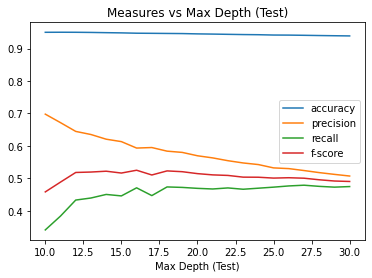

In [329]:
entropy_depth_instance_train = np.array(entropy_depth_instance_train)
entropy_depth_instance_test = np.array(entropy_depth_instance_test)
entropy_depth_instance_depths = np.array(entropy_depth_instance_depths)

plot_measures(x, entropy_depth_instance_train, 'Max Depth (Train)')
plot_measures(x, entropy_depth_instance_test, 'Max Depth (Test)', runtime=False)

In [330]:
print(entropy_depth_instance_test[-1])

[ 0.93883443  0.50725389  0.47478177  0.49048096 23.58846593  0.07255626]


## Run weighted DT against different min_impurity_decreases (entropy)

In [332]:
x = [i/(10**7) for i in range(10, 0, -1)]
entropy_impurity_instance_train = []
entropy_impurity_instance_test = []
entropy_impurity_instance_depths = []
for depth in x:
    a,b,c = run_dt_with_params(train_weights=data_weight,min_impurity_decrease=depth, criterion='entropy')
    entropy_impurity_instance_train.append(a)
    entropy_impurity_instance_test.append(b)
    entropy_impurity_instance_depths.append(c)

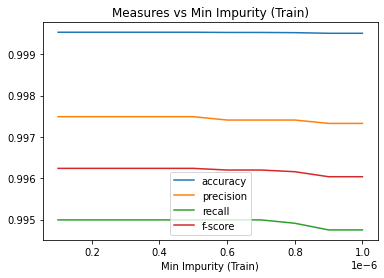

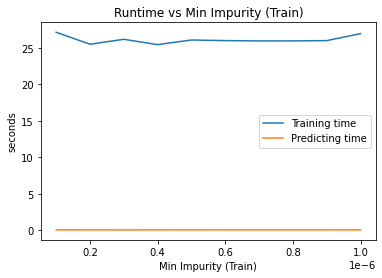

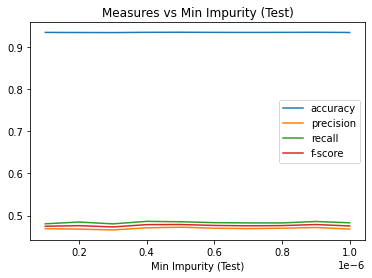

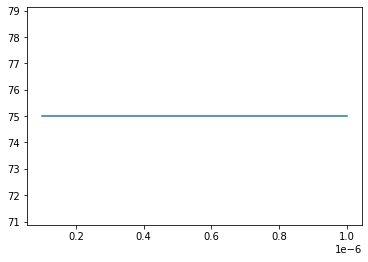

In [333]:
entropy_impurity_instance_train = np.array(entropy_impurity_instance_train)
entropy_impurity_instance_test = np.array(entropy_impurity_instance_test)
entropy_impurity_instance_depths = np.array(entropy_impurity_instance_depths)

plot_measures(x, entropy_impurity_instance_train, 'Min Impurity (Train)')
plot_measures(x, entropy_impurity_instance_test, 'Min Impurity (Test)', runtime=False)

plt.plot(x, entropy_impurity_instance_depths)
plt.show()

In [334]:
print(entropy_impurity_instance_test[-1])

[ 0.93404302  0.46891764  0.4804397   0.47460875 27.11245704  0.07717609]


## Running with XGBoost0

In [254]:
x = [i/(10**7) for i in range(1, 21, 2)]
train_results = []
test_results = []
for mid in x:
    train_result, test_result = run_dt_with_params(
        sparse_data_matrix,
        data_labels,
        train_weights=data_weight,
        min_impurity_decrease=mid,
        boost=True
    )
    train_results.append(train_result)
    test_results.append(test_result)

AttributeError: 'GradientBoostingClassifier' object has no attribute 'tree_'

In [ ]:
boost_gini_train_results = train_results
boost_gini_test_results = test_results

In [ ]:
plot_measures(x, np.array(boost_gini_train_results), 'Train result')
plot_measures(x, np.array(boost_gini_test_results), 'Test result', runtime=False)

# Feature Selection

In [85]:
estimator = DecisionTreeClassifier(min_impurity_decrease=2.1e-05)
selector = RFE(estimator, step=3)
selector = selector.fit(sparse_data_matrix, data_labels)

In [89]:
selector.ranking_

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, 10,  1,  1,  1,  2,  3,  1,  4,  1,  1,  6,  7,  1,
        8,  9,  1,  1,  4,  1, 13,  1, 14,  3,  5, 16, 17,  7, 18,  1,  9,
       20, 21,  8,  1, 23,  6, 11, 25, 11, 26, 27,  1, 28,  1, 22, 30, 31,
        1, 32,  1, 15, 34, 35,  1, 36, 37,  1, 38, 39, 24, 40, 41,  1, 42,
       43, 10, 44, 45,  1, 46, 47,  1, 48,  1,  1, 50, 51,  1, 52, 53, 12,
       54, 55, 12, 56, 57,  1, 58, 59,  1, 60, 61,  1, 62, 63, 19,  1, 65,
        1, 66, 67,  1, 68

In [87]:
supports = selector.support_
print(sum(supports))

251


In [92]:
feature_selections = list(filter(lambda x: supports[x], [i for i in range(len(supports))] ))
feature_selections

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 124,
 125,
 126,
 129,
 131,
 132,
 135,
 138,
 139,
 141,
 143,
 151,
 156,
 164,
 166,
 170,
 172,
 176,
 179,
 185,
 191,
 194,
 196,
 197,
 200,
 209,
 212,
 215,
 219,
 221,
 224,
 227,
 230,
 233,
 236,
 239,
 242,
 245,
 260,
 261,
 262,
 263,
 264,
 265,
 287,
 315,
 352,
 364,
 374,
 399,
 400,
 401,
 402,
 403,
 404,
 405,
 406,
 407,
 408,
 409,
 410,
 411,


In [347]:
r = run_dt_with_params(train_weights=data_weight,min_impurity_decrease=3e-07, feature_selections=feature_selections)
print(r)

(array([ 0.99672218,  0.99219406,  0.9546923 ,  0.97308199, 15.60155892,
        0.06927991]), array([ 0.93461438,  0.47353542,  0.48739088,  0.48036326, 15.60155892,
        0.06927991]), 48)


In [349]:
precision_recall_fscore_support(test_labels, [0]* len(test_labels))

/Users/mute/Library/Python/3.7/lib/python/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.93799242, 0.        ]),
 array([1., 0.]),
 array([0.96800422, 0.        ]),
 array([93576,  6186]))

In [126]:
a,b,c = run_dt_with_params(
    train_weights=data_weight,
    min_impurity_decrease=2.1e-05,
    boost=True,
    feature_selections=feature_selections,
    average='weighted'
)

In [127]:
print(a)
print(b)
print(c)

[9.99323386e-01 9.99322648e-01 9.99323386e-01 9.99322503e-01
 2.03888125e+03 9.47843885e+00]
[9.49580000e-01 9.44106408e-01 9.49580000e-01 9.46018474e-01
 2.03888125e+03 9.47843885e+00]
0


## Should I try dataframe?

In [ ]:
df = pd.read_csv('../census/census-income.data', encoding='utf8', names=(column_names + ['label']))

In [ ]:
df[:3]


In [ ]:
type(df.iat[0,24])